<a href="https://colab.research.google.com/github/mgczacki/iap/blob/main/libretas/Tarea1-Ej4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 1: Perceptrón y Redes Densas

### Notebook 3 de 3

#### Autor: Mario Horacio Garrido Czacki

Resuelve los siguientes ejercicios en libretas de Colab independientes que sean replicables.

#### 4. Entrena una red completamente conectada para clasificaci ́on multiclase en el conjunto CIFAR102. (3 puntos.)

In [1]:
# biblioteca para inspeccionar arquitecturas
# https://github.com/tyleryep/torchinfo
!pip install torchinfo

In [2]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# gráficas
import matplotlib.pyplot as plt
# arreglos multidimensionales
import numpy as np
# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as T
# procesamiento de imágenes
from skimage import io
# redes neuronales
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
# inspección de arquitectura
from torchinfo import summary
# barras de progreso
from tqdm import trange

In [3]:
# parche para bicho en colab
# https://github.com/pytorch/vision/issues/1938
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

In [4]:
# directorio de datos
DATA_DIR = '../datos'

# tamaño del lote
BATCH_SIZE = 128 #NOTA: Aumentado de 32 para tomar ventaja de CUDA/reducir transferencia y maximizar paralelismo
# filas y columnas de la regilla de imágenes
ROWS, COLS = 4, 8

classes_dataset = ['airplane',
                   'automobile',
                   'bird',
                   'cat',
                   'deer',
                   'dog',
                   'frog',
                   'horse',
                   'ship',
                   'truck']


def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
    """Displays examples in a grid."""
    fig, ax = plt.subplots(rows, cols, figsize=figsize)
    i = 0
    for r in range(rows):
        for c in range(cols):
            ax[r, c].imshow(xs[i])
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
            i += 1
    fig.tight_layout()
    plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
    """Displays a batch of processed examples in a grid."""
    # rotamos canales (C x H x W) => (H x W x C)
    x = x.permute(0, 2, 3, 1)
    # desplegamos
    display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

In [5]:
# creamos un Dataset
ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=np.array, 
    # descargar el conjunto
    download=True
)

Files already downloaded and verified


images[0] shape=(32, 32, 3) dtype=uint8


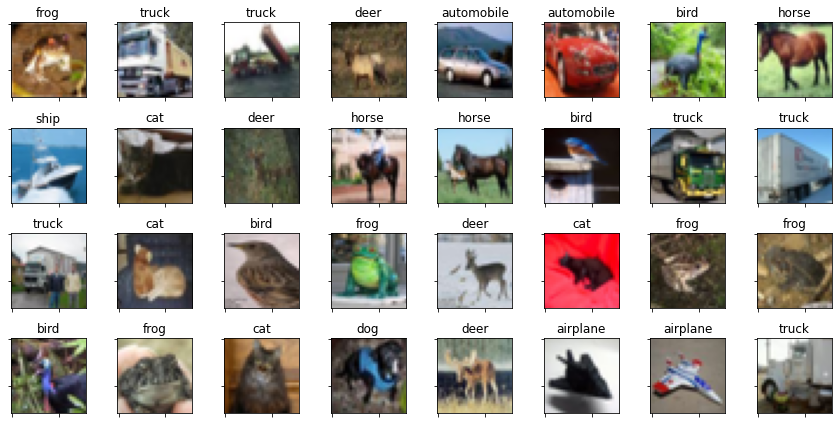

In [6]:
images, labels = [], []
for i in range(BATCH_SIZE):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [classes_dataset[y] for y in labels]
display_grid(images, titles, ROWS, COLS)

x shape=torch.Size([128, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


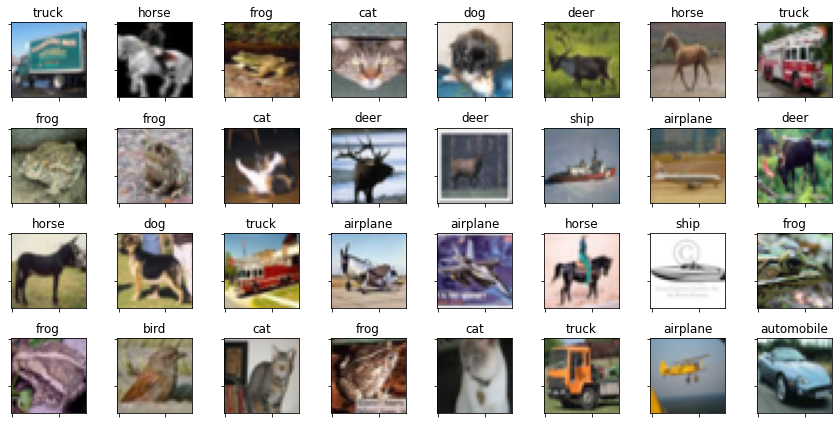

In [7]:
tsfm = T.ToTensor()

# creamos un Dataset
trn_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR,
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(trn_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, [classes_dataset[i] for i in y.tolist()], ROWS, COLS)

x shape=torch.Size([128, 3, 32, 32]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


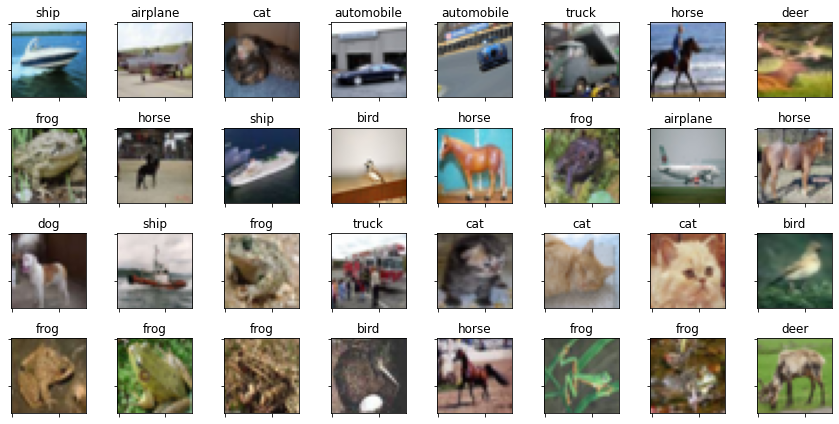

In [8]:
# creamos un Dataset
tst_ds = CIFAR10(
    # directorio de datos
    root=DATA_DIR, 
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
x, y = next(iter(tst_dl))
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
display_batch(x, [classes_dataset[i] for i in y.tolist()], ROWS, COLS)

In [9]:
# definición del modelo
class FCN(nn.Module):
    
    # inicializador
    def __init__(self):
        
        # inicilización del objeto padre, obligatorio
        super(FCN, self).__init__()
        
        # tamaño de las capas
        self.I = 3 * 32 * 32
        FC1, FC2 = 128, 10
        
        # definición de capas
        self.cls = nn.Sequential(
            
            # fc1
            # [M, 3x32x32] => [M, 128]
            nn.Linear(self.I, FC1),
            nn.Sigmoid(),
            
            # fc2
            # [M, 128] => [M, 10]
            nn.Linear(FC1, FC2)
        
        )
    
    # método para inferencia
    def forward(self, x):
        
        # aplanamos los pixeles de la imagen
        # [M, 3, 32, 32] => [M, 3x32x32]
        x = x.view(-1, self.I)
        
        # inferencia
        # [M, 3x32x32]
        x = self.cls(x)
        
        return x
    def pred(self, x):
        x = self.cls(x)
        m = nn.Softmax()
        x = m(x)
        return x

In [10]:
model = FCN()
print(model)

FCN(
  (cls): Sequential(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [11]:
# inferencia con datos sintéticos
x = torch.zeros(1, 3, 32, 32)
y = model(x)
print(f'{x.shape} => {y.shape}')

torch.Size([1, 3, 32, 32]) => torch.Size([1, 10])


In [12]:
summary(model, (3, 32, 32), device='cpu', verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [1, 10]                   --
|    └─Linear: 2-1                       [1, 128]                  393,344
|    └─Sigmoid: 2-2                      [1, 128]                  --
|    └─Linear: 2-3                       [1, 10]                   1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (M): 0.79
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 1.58
Estimated Total Size (MB): 1.59

#### Uso del GPU

In [13]:
#Para usar el GPU si hay
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Ciclo de entrenamiento

In [14]:
def train_epoch(dl, model, opt):

    # por cada lote
    for x, y_true in dl:
        y_true = y_true.to(device)
        
        # computamos logits
        y_lgts = model(x.to(device))
        
        # computamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        
        # vaciamos los gradientes
        opt.zero_grad()
        
        # retropropagamos
        loss.backward()
        
        # actualizamos parámetros
        opt.step()


def eval_epoch(dl, model, num_batches=None):

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # historiales
        losses, accs = [], []

        # validación de la época con num_batches
        # si num_batches==None, se usan todos los lotes
        for x, y_true in take(dl, num_batches):
            y_true = y_true.to(device)
            
            # computamos los logits
            y_lgts = model(x.to(device))

            # computamos los puntajes
            y_prob = F.softmax(y_lgts, 1)

            # computamos la clases
            y_pred = torch.argmax(y_prob, 1)

            # computamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)

            # computamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item())
            accs.append(acc.item())

        # promediamos
        loss = np.mean(losses) * 100
        acc = np.mean(accs) * 100

        return loss, acc
        
        
def train(model, trn_dl, tst_dl, lr=1e-3, epochs=20,
          trn_batches=None, tst_batches=None, optimizer = optim.SGD):

    # historiales
    loss_hist, acc_hist = [], []
    
    # optimizador
    opt = optimizer(model.parameters(), lr=lr)

    # ciclo de entrenamiento
    for epoch in trange(epochs):

        # entrenamos la época
        train_epoch(trn_dl, model, opt)

        # evaluamos la época en entrenamiento
        trn_loss, trn_acc = eval_epoch(trn_dl, model, trn_batches)
        # evaluamos la época en prueba
        tst_loss, tst_acc = eval_epoch(tst_dl, model, tst_batches)

        # guardamos historial
        loss_hist.append([trn_loss, tst_loss])
        acc_hist.append([trn_acc, tst_acc])

        # imprimimos progreso
        print(f'E{epoch:02} '
              f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
              f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

    return loss_hist, acc_hist

In [15]:
# instanciamos un modelo
model = FCN().to(device)
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl)

  5%|▌         | 1/20 [00:11<03:42, 11.72s/it]

E00 loss=[229.20,229.18] acc=[15.81,15.92]


 10%|█         | 2/20 [00:22<03:23, 11.32s/it]

E01 loss=[228.25,228.21] acc=[16.24,16.46]


 15%|█▌        | 3/20 [00:34<03:12, 11.33s/it]

E02 loss=[227.37,227.32] acc=[18.95,19.02]


 20%|██        | 4/20 [00:45<03:01, 11.36s/it]

E03 loss=[226.53,226.44] acc=[22.01,21.90]


 25%|██▌       | 5/20 [00:57<02:54, 11.62s/it]

E04 loss=[225.70,225.63] acc=[23.31,23.48]


 30%|███       | 6/20 [01:09<02:42, 11.59s/it]

E05 loss=[224.89,224.83] acc=[24.63,24.95]


 35%|███▌      | 7/20 [01:20<02:29, 11.49s/it]

E06 loss=[224.09,223.96] acc=[25.67,26.02]


 40%|████      | 8/20 [01:31<02:15, 11.33s/it]

E07 loss=[223.29,223.26] acc=[26.29,26.68]


 45%|████▌     | 9/20 [01:42<02:04, 11.31s/it]

E08 loss=[222.49,222.40] acc=[26.26,26.56]


 50%|█████     | 10/20 [01:53<01:52, 11.28s/it]

E09 loss=[221.69,221.58] acc=[27.21,27.65]


 55%|█████▌    | 11/20 [02:05<01:41, 11.26s/it]

E10 loss=[220.88,220.80] acc=[27.34,27.82]


 60%|██████    | 12/20 [02:16<01:30, 11.29s/it]

E11 loss=[220.06,219.95] acc=[27.65,27.82]


 65%|██████▌   | 13/20 [02:27<01:18, 11.26s/it]

E12 loss=[219.24,219.14] acc=[27.96,27.99]


 70%|███████   | 14/20 [02:39<01:07, 11.30s/it]

E13 loss=[218.42,218.41] acc=[28.37,28.42]


 75%|███████▌  | 15/20 [02:50<00:56, 11.30s/it]

E14 loss=[217.61,217.54] acc=[28.63,28.86]


 80%|████████  | 16/20 [03:01<00:45, 11.36s/it]

E15 loss=[216.80,216.71] acc=[28.87,29.16]


 85%|████████▌ | 17/20 [03:12<00:33, 11.27s/it]

E16 loss=[215.99,215.83] acc=[28.85,29.16]


 90%|█████████ | 18/20 [03:23<00:22, 11.18s/it]

E17 loss=[215.20,215.10] acc=[28.96,29.25]


 95%|█████████▌| 19/20 [03:34<00:11, 11.16s/it]

E18 loss=[214.43,214.24] acc=[29.01,29.37]


100%|██████████| 20/20 [03:46<00:00, 11.31s/it]

E19 loss=[213.66,213.55] acc=[29.25,29.53]


#### Gráficas de pérdidas y exactitud

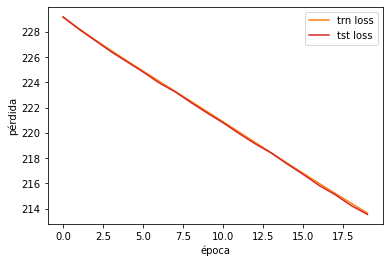

In [16]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

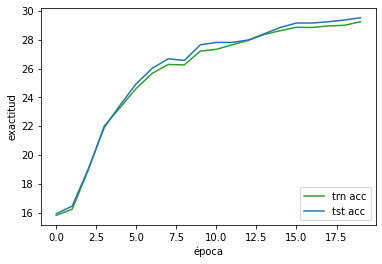

In [17]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

#### Evaluación

In [18]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[213.66,213.60] acc=[29.25,29.60]


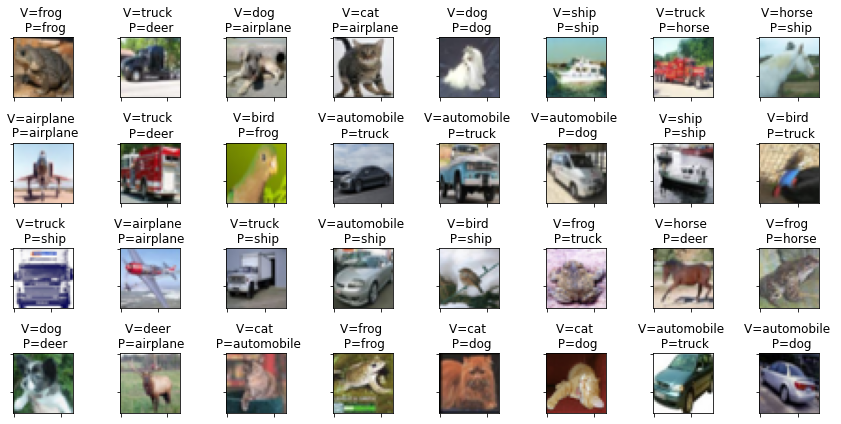

In [19]:
with torch.no_grad(): 
    x_o, y_true_o = next(iter(tst_dl))
    x = x_o.to(device)
    y_true = y_true_o.to(device)
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1).cpu()
    titles = [f'V={t} \n P={p}' for t, p in zip([classes_dataset[i] for i in y_true_o], 
                                                [classes_dataset[i] for i in y_pred])]
    display_batch(x_o, titles, ROWS, COLS)

Claramente está subentrenada la red. Primero que nada cambiaré el optimizador a Adam ya que funciona bastante bien sin tener que experimentar demasiado con el learning rate. Modifiqué la función train con esta finalidad.

In [20]:
# instanciamos un modelo
model = FCN().to(device)
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl, optimizer = optim.Adam)

  5%|▌         | 1/20 [00:11<03:38, 11.50s/it]

E00 loss=[175.24,175.74] acc=[38.39,38.54]


 10%|█         | 2/20 [00:22<03:25, 11.42s/it]

E01 loss=[168.04,169.05] acc=[40.82,40.46]


 15%|█▌        | 3/20 [00:34<03:13, 11.40s/it]

E02 loss=[161.48,162.94] acc=[43.15,41.94]


 20%|██        | 4/20 [00:45<03:02, 11.39s/it]

E03 loss=[158.16,160.67] acc=[44.48,43.38]


 25%|██▌       | 5/20 [00:56<02:50, 11.39s/it]

E04 loss=[155.52,158.51] acc=[45.28,44.01]


 30%|███       | 6/20 [01:08<02:42, 11.59s/it]

E05 loss=[149.87,153.86] acc=[47.32,45.93]


 35%|███▌      | 7/20 [01:20<02:30, 11.57s/it]

E06 loss=[147.83,153.37] acc=[48.08,45.52]


 40%|████      | 8/20 [01:31<02:17, 11.46s/it]

E07 loss=[146.90,152.97] acc=[48.29,46.09]


 45%|████▌     | 9/20 [01:42<02:04, 11.36s/it]

E08 loss=[146.27,152.60] acc=[48.19,45.75]


 50%|█████     | 10/20 [01:54<01:53, 11.32s/it]

E09 loss=[141.86,149.74] acc=[49.62,46.74]


 55%|█████▌    | 11/20 [02:05<01:41, 11.32s/it]

E10 loss=[140.32,148.29] acc=[50.31,47.43]


 60%|██████    | 12/20 [02:16<01:30, 11.25s/it]

E11 loss=[139.69,148.67] acc=[50.44,47.08]


 65%|██████▌   | 13/20 [02:27<01:19, 11.31s/it]

E12 loss=[137.32,147.31] acc=[51.91,48.34]


 70%|███████   | 14/20 [02:39<01:07, 11.32s/it]

E13 loss=[136.69,147.63] acc=[51.61,48.02]


 75%|███████▌  | 15/20 [02:50<00:56, 11.32s/it]

E14 loss=[135.83,146.71] acc=[52.12,48.24]


 80%|████████  | 16/20 [03:01<00:45, 11.31s/it]

E15 loss=[131.75,144.10] acc=[53.61,48.54]


 85%|████████▌ | 17/20 [03:13<00:34, 11.34s/it]

E16 loss=[131.83,144.90] acc=[53.57,49.20]


 90%|█████████ | 18/20 [03:25<00:23, 11.55s/it]

E17 loss=[129.51,142.49] acc=[54.55,49.23]


 95%|█████████▌| 19/20 [03:36<00:11, 11.51s/it]

E18 loss=[128.82,142.72] acc=[54.74,49.18]


100%|██████████| 20/20 [03:48<00:00, 11.40s/it]

E19 loss=[127.57,143.03] acc=[55.27,49.88]


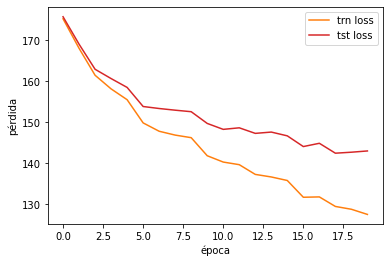

In [21]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

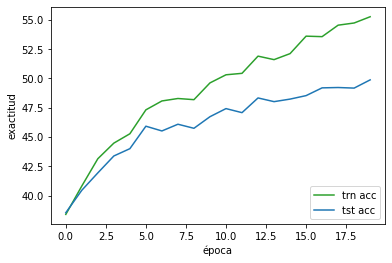

In [22]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [23]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[127.58,143.04] acc=[55.27,49.88]


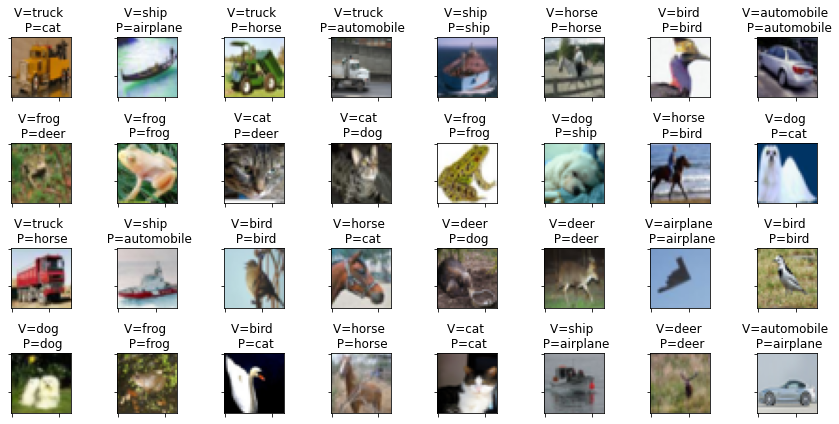

In [24]:
with torch.no_grad(): 
    x_o, y_true_o = next(iter(tst_dl))
    x = x_o.to(device)
    y_true = y_true_o.to(device)
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1).cpu()
    titles = [f'V={t} \n P={p}' for t, p in zip([classes_dataset[i] for i in y_true_o], 
                                                [classes_dataset[i] for i in y_pred])]
    display_batch(x_o, titles, ROWS, COLS)

Parece hacerlo mejor. Parecería que se está sobreentrenando la red muy rápido así que haré un par de cambios (aunque por lo general se debería ortogonalizar, haciendo un cambio a la vez). Lo que haré será:
- Usar una activación ReLU en vez de sigmoide.
- Más épocas

Seguiré usando Adam.

In [27]:
# definición del modelo
class FCN2(nn.Module):
    
    # inicializador
    def __init__(self):
        
        # inicilización del objeto padre, obligatorio
        super(FCN2, self).__init__()
        
        # tamaño de las capas
        self.I = 3 * 32 * 32
        FC1, FC2 = 128, 10
        
        # definición de capas
        self.cls = nn.Sequential(
            
            # fc1
            # [M, 3x32x32] => [M, 128]
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            
            # fc2
            # [M, 128] => [M, 10]
            nn.Linear(FC1, FC2)
        
        )
    
    # método para inferencia
    def forward(self, x):
        
        # aplanamos los pixeles de la imagen
        # [M, 3, 32, 32] => [M, 3x32x32]
        x = x.view(-1, self.I)
        
        # inferencia
        # [M, 3x32x32]
        x = self.cls(x)
        
        return x
    def pred(self, x):
        x = self.cls(x)
        m = nn.Softmax()
        x = m(x)
        return x

In [28]:
# instanciamos un modelo
model = FCN2().to(device)
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl, optimizer = optim.Adam, epochs = 40)

  2%|▎         | 1/40 [00:11<07:29, 11.52s/it]

E00 loss=[175.39,175.57] acc=[37.87,37.51]


  5%|▌         | 2/40 [00:22<07:13, 11.40s/it]

E01 loss=[167.15,167.61] acc=[41.15,41.20]


  8%|▊         | 3/40 [00:34<07:02, 11.42s/it]

E02 loss=[163.09,163.82] acc=[41.56,41.09]


 10%|█         | 4/40 [00:45<06:51, 11.43s/it]

E03 loss=[158.42,160.72] acc=[43.70,42.81]


 12%|█▎        | 5/40 [00:57<06:40, 11.44s/it]

E04 loss=[155.47,158.48] acc=[44.59,43.17]


 15%|█▌        | 6/40 [01:08<06:28, 11.44s/it]

E05 loss=[156.39,160.15] acc=[44.31,42.36]


 18%|█▊        | 7/40 [01:19<06:15, 11.38s/it]

E06 loss=[150.74,155.17] acc=[46.58,44.66]


 20%|██        | 8/40 [01:30<06:00, 11.28s/it]

E07 loss=[147.91,153.60] acc=[47.90,45.80]


 22%|██▎       | 9/40 [01:42<05:49, 11.28s/it]

E08 loss=[148.31,153.79] acc=[47.83,45.56]


 25%|██▌       | 10/40 [01:53<05:40, 11.35s/it]

E09 loss=[146.52,153.03] acc=[48.02,45.21]


 28%|██▊       | 11/40 [02:04<05:27, 11.29s/it]

E10 loss=[143.28,149.39] acc=[49.80,47.69]


 30%|███       | 12/40 [02:16<05:17, 11.34s/it]

E11 loss=[144.56,153.16] acc=[48.89,45.60]


 32%|███▎      | 13/40 [02:27<05:06, 11.35s/it]

E12 loss=[144.26,152.62] acc=[49.01,46.15]


 35%|███▌      | 14/40 [02:39<04:55, 11.37s/it]

E13 loss=[145.00,153.54] acc=[49.25,45.92]


 38%|███▊      | 15/40 [02:50<04:46, 11.45s/it]

E14 loss=[143.48,152.18] acc=[48.70,45.60]


 40%|████      | 16/40 [03:02<04:33, 11.41s/it]

E15 loss=[141.20,150.41] acc=[50.12,47.06]


 42%|████▎     | 17/40 [03:13<04:20, 11.32s/it]

E16 loss=[135.81,145.51] acc=[52.20,48.52]


 45%|████▌     | 18/40 [03:24<04:08, 11.29s/it]

E17 loss=[138.37,149.45] acc=[51.39,47.63]


 48%|████▊     | 19/40 [03:35<03:57, 11.33s/it]

E18 loss=[135.02,145.91] acc=[52.64,48.61]


 50%|█████     | 20/40 [03:47<03:47, 11.39s/it]

E19 loss=[136.11,147.17] acc=[52.11,48.14]


 52%|█████▎    | 21/40 [03:58<03:36, 11.39s/it]

E20 loss=[134.38,145.20] acc=[52.84,48.86]


 55%|█████▌    | 22/40 [04:10<03:25, 11.41s/it]

E21 loss=[135.49,147.16] acc=[51.96,47.91]


 57%|█████▊    | 23/40 [04:21<03:14, 11.43s/it]

E22 loss=[135.29,147.12] acc=[52.26,48.14]


 60%|██████    | 24/40 [04:32<03:00, 11.30s/it]

E23 loss=[133.58,146.74] acc=[53.03,48.49]


 62%|██████▎   | 25/40 [04:43<02:49, 11.27s/it]

E24 loss=[131.24,144.71] acc=[53.82,48.66]


 65%|██████▌   | 26/40 [04:55<02:38, 11.31s/it]

E25 loss=[134.84,148.95] acc=[52.20,47.60]


 68%|██████▊   | 27/40 [05:06<02:27, 11.33s/it]

E26 loss=[133.08,146.92] acc=[52.69,48.06]


 70%|███████   | 28/40 [05:17<02:14, 11.25s/it]

E27 loss=[131.81,146.48] acc=[53.68,48.21]


 72%|███████▎  | 29/40 [05:29<02:04, 11.31s/it]

E28 loss=[131.98,147.29] acc=[53.50,48.40]


 75%|███████▌  | 30/40 [05:40<01:53, 11.31s/it]

E29 loss=[132.67,148.18] acc=[53.23,47.67]


 78%|███████▊  | 31/40 [05:51<01:41, 11.32s/it]

E30 loss=[134.07,150.64] acc=[52.56,46.96]


 80%|████████  | 32/40 [06:03<01:30, 11.30s/it]

E31 loss=[129.19,144.64] acc=[54.11,49.01]


 82%|████████▎ | 33/40 [06:14<01:18, 11.25s/it]

E32 loss=[128.02,144.28] acc=[55.06,48.69]


 85%|████████▌ | 34/40 [06:25<01:06, 11.16s/it]

E33 loss=[130.50,147.24] acc=[53.56,47.58]


 88%|████████▊ | 35/40 [06:36<00:56, 11.21s/it]

E34 loss=[127.65,143.68] acc=[55.07,49.26]


 90%|█████████ | 36/40 [06:48<00:45, 11.32s/it]

E35 loss=[129.76,146.12] acc=[53.99,48.21]


 92%|█████████▎| 37/40 [06:59<00:34, 11.36s/it]

E36 loss=[130.31,146.74] acc=[53.72,48.05]


 95%|█████████▌| 38/40 [07:10<00:22, 11.35s/it]

E37 loss=[128.69,146.11] acc=[54.16,48.30]


 98%|█████████▊| 39/40 [07:22<00:11, 11.40s/it]

E38 loss=[127.20,145.29] acc=[54.93,48.13]


100%|██████████| 40/40 [07:33<00:00, 11.34s/it]

E39 loss=[126.26,145.00] acc=[55.50,48.65]


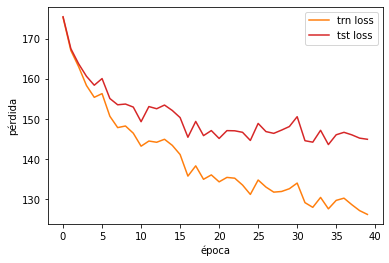

In [29]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

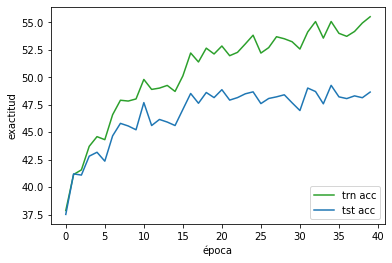

In [30]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

In [31]:
# evaluamos en entrenamiento
trn_loss, trn_acc = eval_epoch(trn_dl, model)
# evaluamos en prueba
tst_loss, tst_acc = eval_epoch(tst_dl, model)
print(f'loss=[{trn_loss:6.2f},{tst_loss:6.2f}] '
      f'acc=[{trn_acc:5.2f},{tst_acc:5.2f}]')

loss=[126.28,144.28] acc=[55.49,48.71]


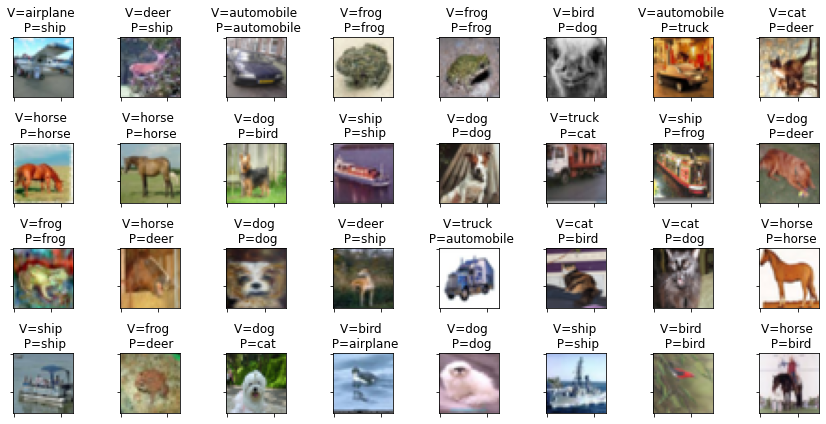

In [32]:
with torch.no_grad(): 
    x_o, y_true_o = next(iter(tst_dl))
    x = x_o.to(device)
    y_true = y_true_o.to(device)
    y_lgts = model(x)
    y_prob = F.softmax(y_lgts, 1)
    y_pred = torch.argmax(y_prob, 1).cpu()
    titles = [f'V={t} \n P={p}' for t, p in zip([classes_dataset[i] for i in y_true_o], 
                                                [classes_dataset[i] for i in y_pred])]
    display_batch(x_o, titles, ROWS, COLS)

Parece que cambiar la función de activación no ayudó (de hecho parece haber bajado un poco el performance en el conjunto de prueba).

Por ahora me quedaré con la ReLU. Asimismo, el sesgo evitable es de casi el 50% mientras la diferencia entre accuracy en training y test es mucho menor. Esto implica que tener una arquitectura más compleja podría ser beneficioso. Aumentaré una capa oculta.

Como cambió el número de parámetros, un learning rate ligeramente mayor podría mejorar la convergencia. Seguiré con Adam.

In [42]:
# definición del modelo
class FCN3(nn.Module):
    
    # inicializador
    def __init__(self):
        
        # inicilización del objeto padre, obligatorio
        super(FCN3, self).__init__()
        
        # tamaño de las capas
        self.I = 3 * 32 * 32
        FC1, FC2, FC3 = 128, 64, 10
        
        # definición de capas
        self.cls = nn.Sequential(
            
            # fc1
            # [M, 3x32x32] => [M, 128]
            nn.Linear(self.I, FC1),
            nn.ReLU(),
            
            
            # fc2
            # [M, 128] => [M, 64]
            nn.Linear(FC1, FC2),
            nn.ReLU(),
            
            # fc3
            # [M, 64] => [M, 10]
            nn.Linear(FC2, FC3)
        
        )
    
    # método para inferencia
    def forward(self, x):
        
        # aplanamos los pixeles de la imagen
        # [M, 3, 32, 32] => [M, 3x32x32]
        x = x.view(-1, self.I)
        
        # inferencia
        # [M, 3x32x32]
        x = self.cls(x)
        
        return x
    def pred(self, x):
        x = self.cls(x)
        m = nn.Softmax()
        x = m(x)
        return x

In [43]:
# instanciamos un modelo
model = FCN3().to(device)
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl, optimizer = optim.Adam, epochs = 40, lr = 1e-2)

  2%|▎         | 1/40 [00:11<07:23, 11.38s/it]

E00 loss=[184.53,184.46] acc=[33.00,32.69]


  5%|▌         | 2/40 [00:22<07:14, 11.44s/it]

E01 loss=[192.68,192.65] acc=[29.12,29.25]


  8%|▊         | 3/40 [00:34<07:06, 11.52s/it]

E02 loss=[180.59,181.25] acc=[34.04,33.76]


 10%|█         | 4/40 [00:46<06:55, 11.55s/it]

E03 loss=[181.62,182.66] acc=[34.20,33.19]


 12%|█▎        | 5/40 [00:57<06:44, 11.55s/it]

E04 loss=[180.76,181.80] acc=[34.43,34.11]


 15%|█▌        | 6/40 [01:09<06:33, 11.58s/it]

E05 loss=[178.53,179.87] acc=[35.03,34.21]


 18%|█▊        | 7/40 [01:20<06:23, 11.62s/it]

E06 loss=[177.77,179.07] acc=[35.18,34.38]


 20%|██        | 8/40 [01:32<06:12, 11.64s/it]

E07 loss=[179.77,181.43] acc=[33.96,32.86]


 22%|██▎       | 9/40 [01:44<06:00, 11.63s/it]

E08 loss=[185.50,186.66] acc=[32.13,31.66]


 25%|██▌       | 10/40 [01:55<05:48, 11.62s/it]

E09 loss=[177.59,179.18] acc=[35.27,35.07]


 28%|██▊       | 11/40 [02:07<05:37, 11.63s/it]

E10 loss=[180.08,181.57] acc=[34.38,32.95]


 30%|███       | 12/40 [02:19<05:25, 11.61s/it]

E11 loss=[178.37,180.24] acc=[34.10,32.93]


 32%|███▎      | 13/40 [02:30<05:11, 11.53s/it]

E12 loss=[177.36,179.43] acc=[35.55,34.58]


 35%|███▌      | 14/40 [02:42<05:01, 11.61s/it]

E13 loss=[178.15,180.46] acc=[35.31,34.59]


 38%|███▊      | 15/40 [02:53<04:48, 11.56s/it]

E14 loss=[179.33,180.75] acc=[35.16,34.92]


 40%|████      | 16/40 [03:05<04:38, 11.59s/it]

E15 loss=[179.50,181.52] acc=[33.90,32.82]


 42%|████▎     | 17/40 [03:17<04:27, 11.65s/it]

E16 loss=[177.75,179.98] acc=[33.68,32.65]


 45%|████▌     | 18/40 [03:28<04:14, 11.56s/it]

E17 loss=[181.11,182.80] acc=[34.26,34.00]


 48%|████▊     | 19/40 [03:40<04:04, 11.64s/it]

E18 loss=[178.08,180.36] acc=[35.10,33.94]


 50%|█████     | 20/40 [03:51<03:51, 11.60s/it]

E19 loss=[175.56,178.34] acc=[35.51,34.91]


 52%|█████▎    | 21/40 [04:03<03:39, 11.54s/it]

E20 loss=[181.13,183.52] acc=[34.00,32.73]


 55%|█████▌    | 22/40 [04:14<03:27, 11.53s/it]

E21 loss=[176.55,178.73] acc=[35.23,34.40]


 57%|█████▊    | 23/40 [04:26<03:17, 11.60s/it]

E22 loss=[177.22,179.27] acc=[34.95,33.57]


 60%|██████    | 24/40 [04:37<03:04, 11.53s/it]

E23 loss=[180.21,183.10] acc=[34.29,33.47]


 62%|██████▎   | 25/40 [04:49<02:53, 11.59s/it]

E24 loss=[175.20,178.18] acc=[35.78,34.83]


 65%|██████▌   | 26/40 [05:01<02:43, 11.65s/it]

E25 loss=[179.72,182.07] acc=[33.28,32.14]


 68%|██████▊   | 27/40 [05:12<02:30, 11.61s/it]

E26 loss=[176.07,178.96] acc=[35.39,34.38]


 70%|███████   | 28/40 [05:24<02:18, 11.55s/it]

E27 loss=[178.29,181.73] acc=[34.17,32.61]


 72%|███████▎  | 29/40 [05:36<02:08, 11.70s/it]

E28 loss=[175.95,179.11] acc=[36.07,34.97]


 75%|███████▌  | 30/40 [05:48<01:57, 11.76s/it]

E29 loss=[177.46,180.02] acc=[34.65,33.42]


 78%|███████▊  | 31/40 [06:00<01:46, 11.79s/it]

E30 loss=[173.52,175.90] acc=[36.69,35.89]


 80%|████████  | 32/40 [06:11<01:33, 11.70s/it]

E31 loss=[178.65,181.95] acc=[34.06,33.33]


 82%|████████▎ | 33/40 [06:22<01:21, 11.59s/it]

E32 loss=[174.71,178.08] acc=[36.18,34.63]


 85%|████████▌ | 34/40 [06:34<01:09, 11.54s/it]

E33 loss=[175.35,178.82] acc=[35.81,33.53]


 88%|████████▊ | 35/40 [06:45<00:57, 11.55s/it]

E34 loss=[175.20,178.42] acc=[35.76,34.39]


 90%|█████████ | 36/40 [06:57<00:46, 11.58s/it]

E35 loss=[174.21,177.42] acc=[36.40,34.65]


 92%|█████████▎| 37/40 [07:09<00:34, 11.57s/it]

E36 loss=[175.08,178.89] acc=[35.06,33.75]


 95%|█████████▌| 38/40 [07:20<00:23, 11.53s/it]

E37 loss=[176.76,180.38] acc=[35.45,34.58]


 98%|█████████▊| 39/40 [07:32<00:11, 11.59s/it]

E38 loss=[173.90,177.23] acc=[36.00,34.44]


100%|██████████| 40/40 [07:43<00:00, 11.60s/it]

E39 loss=[173.41,176.96] acc=[36.29,35.51]


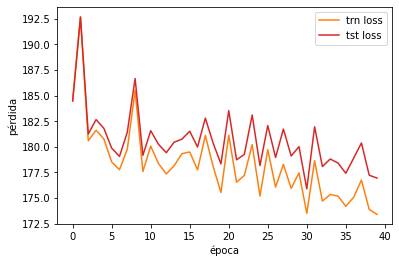

In [44]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

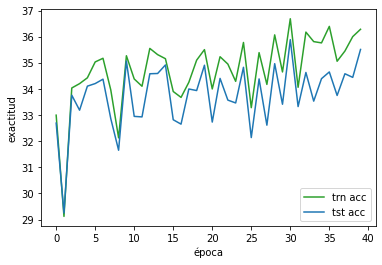

In [45]:
trn_acc, tst_acc = zip(*acc_hist)
plt.plot(trn_acc, 'tab:green', label='trn acc')
plt.plot(tst_acc, 'tab:blue', label='tst acc')
plt.legend(loc='lower right')
plt.xlabel('época')
plt.ylabel('exactitud')
plt.show()

La convergencia parece ser mucho más lenta. Supongo que disminuir el learning rate un poco podría hacer que descienda más rápido.

In [46]:
# instanciamos un modelo
model = FCN3().to(device)
# entrenamos
loss_hist, acc_hist = train(model, trn_dl, tst_dl, optimizer = optim.Adam, epochs = 40, lr = 1e-3)

  2%|▎         | 1/40 [00:11<07:34, 11.65s/it]

E00 loss=[174.17,174.14] acc=[36.55,37.10]


  5%|▌         | 2/40 [00:23<07:18, 11.55s/it]

E01 loss=[163.21,163.65] acc=[41.74,41.03]


  8%|▊         | 3/40 [00:34<07:08, 11.57s/it]

E02 loss=[157.71,159.53] acc=[43.34,43.03]


 10%|█         | 4/40 [00:46<06:58, 11.62s/it]

E03 loss=[153.77,156.53] acc=[45.18,44.23]


 12%|█▎        | 5/40 [00:58<06:46, 11.62s/it]

E04 loss=[151.11,154.10] acc=[45.78,45.00]


 15%|█▌        | 6/40 [01:10<06:40, 11.78s/it]

E05 loss=[146.63,150.50] acc=[47.78,46.74]


 18%|█▊        | 7/40 [01:21<06:28, 11.76s/it]

E06 loss=[144.93,149.20] acc=[48.63,46.47]


 20%|██        | 8/40 [01:33<06:13, 11.66s/it]

E07 loss=[145.68,151.53] acc=[48.31,46.39]


 22%|██▎       | 9/40 [01:45<06:03, 11.72s/it]

E08 loss=[139.50,146.60] acc=[50.25,48.09]


 25%|██▌       | 10/40 [01:56<05:50, 11.68s/it]

E09 loss=[140.78,147.92] acc=[49.89,47.31]


 28%|██▊       | 11/40 [02:08<05:38, 11.66s/it]

E10 loss=[136.01,143.92] acc=[51.30,48.40]


 30%|███       | 12/40 [02:19<05:26, 11.65s/it]

E11 loss=[134.75,143.97] acc=[51.84,48.68]


 32%|███▎      | 13/40 [02:31<05:13, 11.63s/it]

E12 loss=[133.93,144.01] acc=[52.13,48.53]


 35%|███▌      | 14/40 [02:42<05:00, 11.57s/it]

E13 loss=[132.74,143.50] acc=[52.81,49.05]


 38%|███▊      | 15/40 [02:54<04:49, 11.58s/it]

E14 loss=[132.18,143.42] acc=[53.14,48.67]


 40%|████      | 16/40 [03:06<04:38, 11.58s/it]

E15 loss=[130.70,142.44] acc=[53.56,48.87]


 42%|████▎     | 17/40 [03:18<04:28, 11.66s/it]

E16 loss=[127.86,140.86] acc=[54.02,49.23]


 45%|████▌     | 18/40 [03:29<04:16, 11.64s/it]

E17 loss=[126.69,139.99] acc=[54.80,49.96]


 48%|████▊     | 19/40 [03:41<04:05, 11.67s/it]

E18 loss=[122.76,137.22] acc=[56.28,51.43]


 50%|█████     | 20/40 [03:53<03:57, 11.87s/it]

E19 loss=[122.99,138.45] acc=[56.13,50.75]


 52%|█████▎    | 21/40 [04:05<03:45, 11.89s/it]

E20 loss=[122.59,138.22] acc=[56.42,50.62]


 55%|█████▌    | 22/40 [04:17<03:34, 11.91s/it]

E21 loss=[125.98,141.91] acc=[55.14,49.61]


 57%|█████▊    | 23/40 [04:28<03:19, 11.76s/it]

E22 loss=[123.27,139.10] acc=[56.05,50.95]


 60%|██████    | 24/40 [04:40<03:06, 11.64s/it]

E23 loss=[119.93,137.90] acc=[57.25,51.35]


 62%|██████▎   | 25/40 [04:51<02:54, 11.62s/it]

E24 loss=[121.86,139.59] acc=[56.55,50.95]


 65%|██████▌   | 26/40 [05:03<02:43, 11.68s/it]

E25 loss=[121.93,140.22] acc=[56.70,50.37]


 68%|██████▊   | 27/40 [05:15<02:31, 11.63s/it]

E26 loss=[124.28,143.04] acc=[55.44,49.81]


 70%|███████   | 28/40 [05:26<02:19, 11.63s/it]

E27 loss=[117.27,137.74] acc=[58.61,51.67]


 72%|███████▎  | 29/40 [05:38<02:08, 11.69s/it]

E28 loss=[123.08,143.87] acc=[55.70,49.19]


 75%|███████▌  | 30/40 [05:50<01:57, 11.72s/it]

E29 loss=[118.14,138.63] acc=[57.91,51.02]


 78%|███████▊  | 31/40 [06:02<01:45, 11.77s/it]

E30 loss=[117.74,139.88] acc=[58.10,51.11]


 80%|████████  | 32/40 [06:13<01:33, 11.71s/it]

E31 loss=[119.74,141.55] acc=[57.32,50.66]


 82%|████████▎ | 33/40 [06:25<01:22, 11.73s/it]

E32 loss=[117.89,142.90] acc=[57.90,50.66]


 85%|████████▌ | 34/40 [06:37<01:10, 11.78s/it]

E33 loss=[114.66,138.92] acc=[59.29,51.34]


 88%|████████▊ | 35/40 [06:49<00:58, 11.79s/it]

E34 loss=[114.88,138.37] acc=[59.03,51.00]


 90%|█████████ | 36/40 [07:00<00:46, 11.68s/it]

E35 loss=[119.17,144.34] acc=[56.74,50.05]


 92%|█████████▎| 37/40 [07:12<00:34, 11.56s/it]

E36 loss=[113.55,138.95] acc=[59.46,51.19]


 95%|█████████▌| 38/40 [07:23<00:22, 11.50s/it]

E37 loss=[112.80,139.21] acc=[59.78,51.10]


 98%|█████████▊| 39/40 [07:35<00:11, 11.55s/it]

E38 loss=[115.07,140.38] acc=[59.05,50.39]


100%|██████████| 40/40 [07:46<00:00, 11.66s/it]

E39 loss=[111.89,139.20] acc=[60.27,51.46]


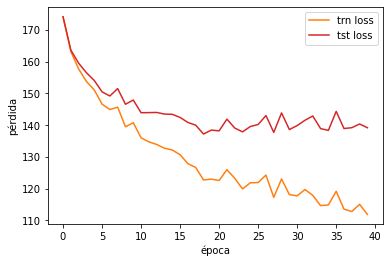

In [47]:
trn_loss, tst_loss = zip(*loss_hist)
plt.plot(trn_loss, 'tab:orange', label='trn loss')
plt.plot(tst_loss, 'tab:red', label='tst loss')
plt.legend(loc='upper right')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

Parece que se estancó la habilidad de generalización de la red. Pienso que algún método de regularización o dropout podría ser bueno (aunque tal vez intentar con más iteraciones podría darme más contexto). No obstante, creo que a la larga la arquitectura de la red no ayuda mucho y sería mucho mejor utilizar algo del estilo de una red convolucional.